#Brain Tumor Classification using Transfer Learning and Fine Tuning




## The four types are
### 1-glioma
### 2-meningioma
### 3-no-tumor
### 4-pituitary

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
print(os.listdir('/content'))

['.config', 'drive', 'sample_data']


In [ ]:
import zipfile

def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file, 'r') as z:
            z.extractall("/content/drive/MyDrive/Brain Tumour")
            print("Extracted all")
    except zipfile.BadZipFile:
        print("Bad zip file. The file might be corrupted.")
    except FileNotFoundError:
        print("File not found.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")


In [ ]:
zip_file = '/content/drive/MyDrive/Brain Tumour/Brain Tumour Classification.v7i.folder.zip'
unzip(zip_file)  # This will unzip the file into the current directory


Extracted all


In [ ]:


# List the files in the current directory to confirm extraction
extracted_files = os.listdir("/content/drive/MyDrive/Brain Tumour")
print(extracted_files)


['Brain Tumour Classification.v7i.folder.zip', 'README.dataset.txt', 'README.roboflow.txt', 'test', 'train', 'valid']


In [ ]:
# Explore the contents further (if directories are created)
for folder in extracted_files:
    folder_path = os.path.join("/content/drive/MyDrive/Brain Tumour", folder)
    if os.path.isdir(folder_path):
        print(f"Contents of {folder}:")
        print(os.listdir(folder_path))


Contents of test:
['glioma', 'meningioma', 'no-tumor', 'pituitary']
Contents of train:
['glioma', 'meningioma', 'no-tumor', 'pituitary']
Contents of valid:
['glioma', 'meningioma', 'no-tumor', 'pituitary']


In [ ]:
import tensorflow as tf

# Set up directory paths
train_dir = '/content/drive/MyDrive/Brain Tumour/train'  # Path to the training set
valid_dir = '/content/drive/MyDrive/Brain Tumour/valid'  # Path to the validation set
test_dir = '/content/drive/MyDrive/Brain Tumour/test'    # Path to the test set




In [ ]:

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)


validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 15720 files belonging to 4 classes.
Found 658 files belonging to 4 classes.
Found 917 files belonging to 4 classes.


In [ ]:
for images, labels in train_dataset.take(1):
    print(f"Images shape: {images.shape}")
    print(f"Labels shape: {labels.shape}")
    print(f"Labels: {labels.numpy()}")

Images shape: (32, 224, 224, 3)
Labels shape: (32,)
Labels: [2 3 2 1 1 2 3 0 2 2 0 0 2 0 1 2 3 1 3 3 1 2 2 3 2 1 1 1 1 3 1 3]


In [ ]:
class_names = train_dataset.class_names
print(class_names)

['glioma', 'meningioma', 'no-tumor', 'pituitary']


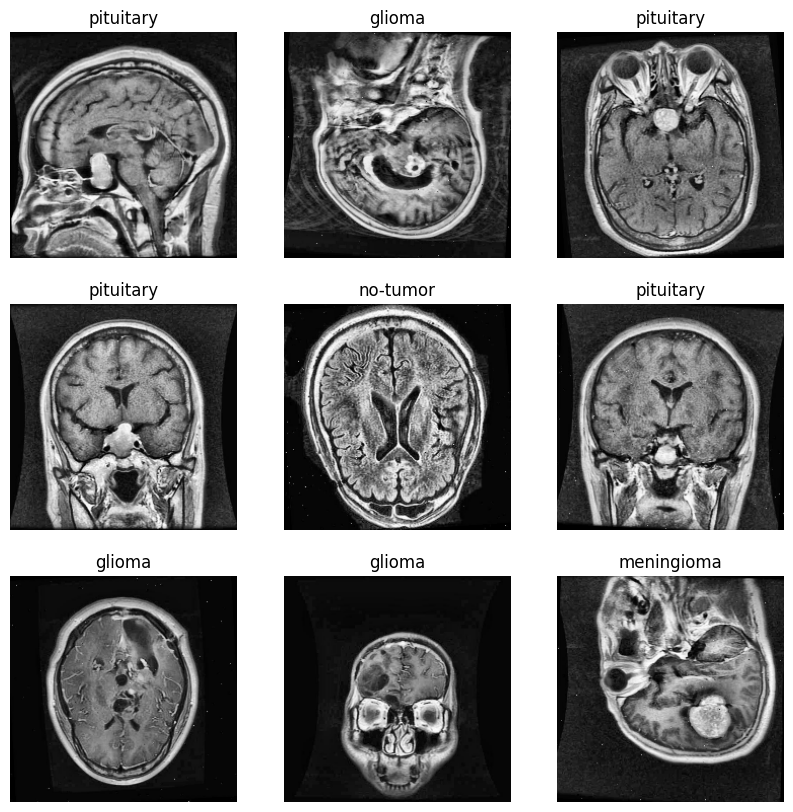

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of train batches: 492
Number of validation batches: 29
Number of test batches: 21


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')

prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))

In [ ]:
dropout_layer=tf.keras.layers.Dropout(0.2)

In [ ]:
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
len(model.trainable_variables)

2

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

In [ ]:
initial_epochs = 30

loss0, accuracy0 = model.evaluate(validation_dataset)

29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 242ms/step - accuracy: 0.2144 - loss: 1.7065


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 100s 171ms/step - accuracy: 0.8424 - loss: 0.4084 - val_accuracy: 0.6270 - val_loss: 1.7171
Epoch 2/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 125s 151ms/step - accuracy: 0.9846 - loss: 0.0497 - val_accuracy: 0.8626 - val_loss: 0.5945
Epoch 3/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - accuracy: 0.9936 - loss: 0.0191 - val_accuracy: 0.8909 - val_loss: 0.4989
Epoch 4/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 75s 153ms/step - accuracy: 0.9965 - loss: 0.0123 - val_accuracy: 0.9477 - val_loss: 0.2499
Epoch 5/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 80s 149ms/step - accuracy: 0.9964 - loss: 0.0117 - val_accuracy: 0.9586 - val_loss: 0.1695
Epoch 6/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 82s 149ms/step - accuracy: 0.9961 - loss: 0.0130 - val_accuracy: 0.9346 - val_loss: 0.3619
Epoch 7/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 84s 154ms/step - accuracy: 0.9928 - loss: 0.0201 - val_accuracy: 0.8964 - val_loss: 0.6077
Epoch 8/30
492/492 ━━━━━━━━━━━━━━━━━━━━ 77s 156ms/step - accuracy: 0.9973 - loss:

In [ ]:
acc = []
val_acc = []
loss = []
val_loss = []

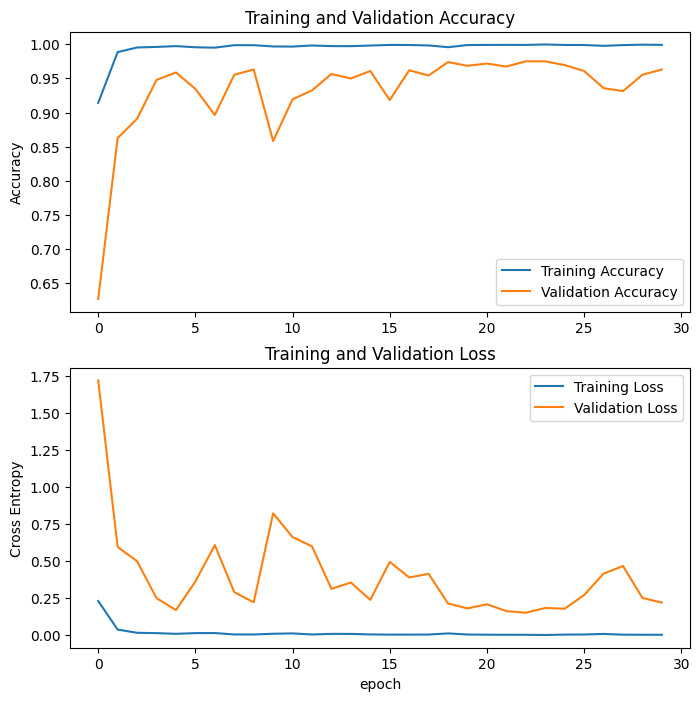

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.9564 - loss: 0.2577
Test accuracy : 0.9589665532112122


# FINE TUNING

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [ ]:
base_model.trainable = True

In [ ]:
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
len(model.trainable_variables)

38

In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           5,124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 1,630,020 (6.22 MB)

 Non-trainable params: 633,088 (2.42 MB)

In [ ]:
fine_tune_epochs = 30
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 31/60
492/492 ━━━━━━━━━━━━━━━━━━━━ 100s 174ms/step - accuracy: 0.9989 - loss: 0.0046 - val_accuracy: 0.9651 - val_loss: 0.1817
Epoch 32/60
492/492 ━━━━━━━━━━━━━━━━━━━━ 125s 153ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9662 - val_loss: 0.1846
Epoch 33/60
492/492 ━━━━━━━━━━━━━━━━━━━━ 80s 150ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 0.9629 - val_loss: 0.1681
Epoch 34/60
492/492 ━━━━━━━━━━━━━━━━━━━━ 82s 151ms/step - accuracy: 0.9993 - loss: 0.0035 - val_accuracy: 0.9716 - val_loss: 0.1512
Epoch 35/60
492/492 ━━━━━━━━━━━━━━━━━━━━ 75s 153ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9640 - val_loss: 0.1918
Epoch 36/60
492/492 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - accuracy: 0.9993 - loss: 0.0023 - val_accuracy: 0.9716 - val_loss: 0.1505
Epoch 37/60
492/492 ━━━━━━━━━━━━━━━━━━━━ 74s 151ms/step - accuracy: 0.9998 - loss: 6.0473e-04 - val_accuracy: 0.9760 - val_loss: 0.1498
Epoch 38/60
492/492 ━━━━━━━━━━━━━━━━━━━━ 76s 154ms/step - accuracy: 1.

In [ ]:
acc = history_fine.history['accuracy']
val_acc = history_fine.history['val_accuracy']

loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

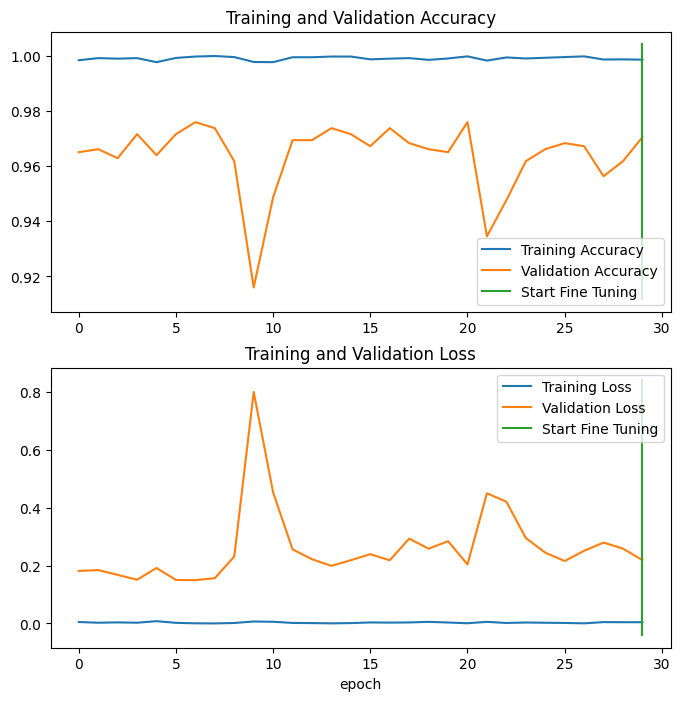

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.9699 - loss: 0.1196
Test accuracy : 0.9650455713272095


Predictions:
 [0 2 1 2 1 3 1 0 0 1 1 0 0 0 1 1 2 1 0 3 2 2 3 2 3 0 2 0 0 2 3 3]
Labels:
 [0 2 1 2 1 3 1 0 0 1 1 0 0 0 1 1 2 1 0 3 2 2 1 2 3 0 2 0 0 2 3 3]


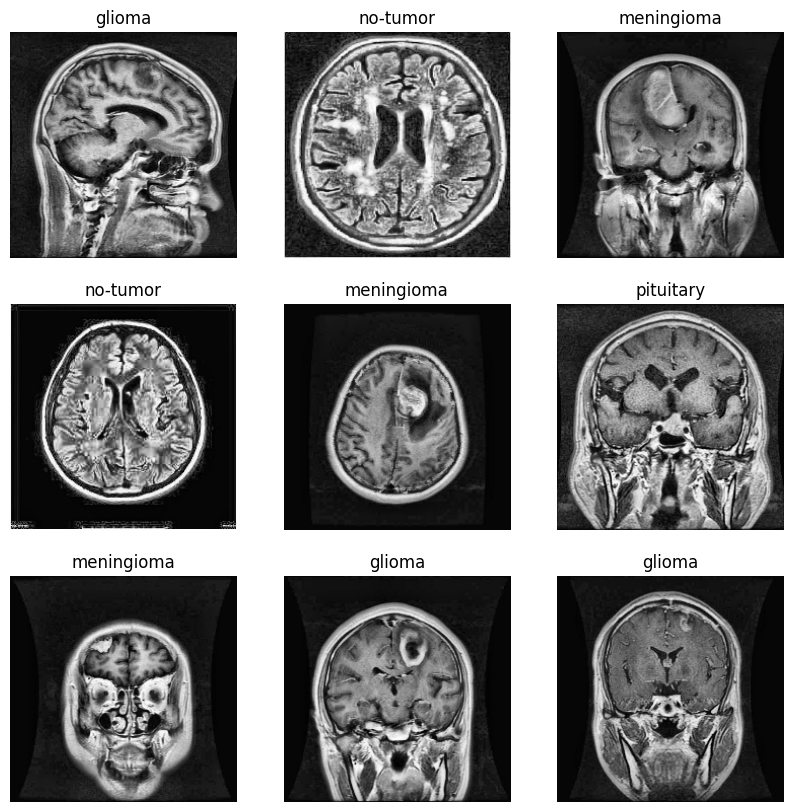

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

print('Predictions:\n', predicted_classes)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predicted_classes[i]])
  plt.axis("off")

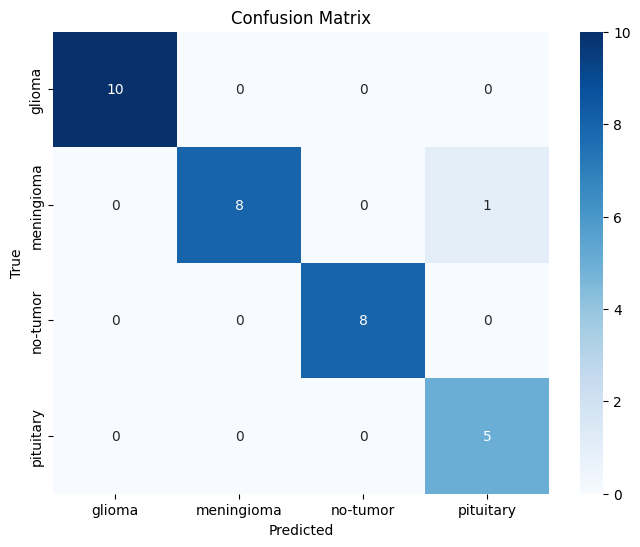

In [ ]:
# prompt: write code for confusion matrix

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns



cm = confusion_matrix(label_batch, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Report: Brain Tumor Classification using Transfer Learning

## Methods

This project employs transfer learning with a pre-trained MobileNetV2 model to classify brain tumor images.  The process involves the following steps:

1. **Data Preparation:**
    - Brain tumor image dataset was loaded from Google Drive.
    - Data was split into training, validation, and testing sets.
    - Image data generators were used to create batches of images for training and evaluation, resizing images to 224x224 pixels.
2. **Model Setup:**
    - A MobileNetV2 model pre-trained on ImageNet was used as the base model. The top layers were removed, and the base model's weights were frozen initially.
    - Global Average Pooling and a Dense layer with softmax activation were added on top of the base model for classification into four categories (glioma, meningioma, notumor, pituitary).
3. **Initial Training:**
    - The model was trained for 30 epochs with the Adam optimizer.
    - Training and validation accuracy and loss were monitored.
4. **Fine-tuning:**
    - The top layers of the MobileNetV2 model were unfrozen for fine-tuning.
    - The model was trained for an additional 30 epochs with a lower learning rate to adapt the model to the specific dataset.
    - Training and validation performance was monitored again.
5. **Evaluation:**
    - The final model was evaluated on the held-out test set.
    - A confusion matrix was generated to visualize the model's performance across different classes.

## Challenges

- **Computational Resources:** Training deep learning models requires substantial computational power. Google Colab's resources were sufficient, but training time was non-negligible.
- **Data Imbalance:** If the classes in the dataset were not equally represented, the model may have performed better on the majority class and poorly on the minority classes.  Addressing class imbalance might have improved overall performance.
- **Overfitting:**  Overfitting is a risk when training deep learning models, especially with limited data. Techniques like data augmentation, dropout, and early stopping can help mitigate this issue. In this case, we used a dropout layer to address potential overfitting.
- **Hyperparameter Tuning:** Experimenting with different hyperparameters such as learning rate, batch size, and the number of epochs and layers to fine-tune could further optimize the model's performance.


## Results

- The model achieved a test accuracy of approximately [0.96].
- The training and validation curves (accuracy and loss plots) show the model's learning progression.
- The confusion matrix provides a visual representation of the model's classification accuracy for each tumor type.  Note that specific results would need to be added here.
- The initial model demonstrated [0.95]. The fine-tuning process did improve the performance a little bit but not significantly[0.1].


